# Import  libraries

In [4]:
%matplotlib inline
import os
import matplotlib
import numpy as np
import pandas as pd 
import sqlite3 as db
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import circmean,circvar 

# Connect to sqlite database where Instacart data is stored

In [5]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    try:
        conn = db.connect(db_file)
        return conn
    except Error as e:
        print(e)
        #conn.close()
    return None
database = '..\\database\\InstacartData.db'
conn = create_connection(database)


# Use days_since_prior_order from last Order for each user as our label
(eval_set labeled == train or test)

In [4]:
users_df = pd.read_sql('select user_id,order_number,days_since_prior_order from orders where eval_set in ("train","test") ', conn)
users_df.head()

,user_id,order_number,days_since_prior_order
0,1,11,14.0
1,2,15,30.0
2,3,13,11.0
3,4,6,30.0
4,5,5,6.0


In [ ]:
users_df = users_df.rename(columns={'days_since_prior_order':'next_purchase_day'})
users_df = users_df.drop('order_number',axis=1)
users_df.head()

Now, we can use days_since_prior_order of the last order as our target label

# Load order_products_prior/orders datasets and the products/depatments/aisles datasets into Dataframes and merge them

In [ ]:
user_order_product_df = pd.read_sql('select * from order_products__prior op join orders o on o.order_id = op.order_id' , conn)
user_order_product_df.head()

In [ ]:
products_df = pd.read_sql('select * from products p join departments d on p.department_id = d.department_id join aisles a on p.aisle_id = a.aisle_id',conn)
products_df.head()

In [ ]:
user_order_product_df = pd.merge(user_order_product_df,products_df[['product_id','department_id','aisle_id']],on='product_id')
user_order_product_df.head()

cleanup user_order_product_df dataset

In [ ]:
user_order_product_df=user_order_product_df.loc[:,~user_order_product_df.columns.duplicated()]
user_order_product_df.head()

# Get total order of prior set of order for each user

In [ ]:
users_df['user_total_prior_orders'] = list(user_order_product_df.groupby(['user_id'])['order_number'].max())
users_df.head()

Check the Distribution of next_purchase_day vs number of users

In [ ]:
users_df[['user_total_prior_orders','next_purchase_day']].hist(figsize=(20,10)) # Histogram for all features

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(x=users_df.next_purchase_day)

plt.title("Distribution of next_purchase_day", fontsize=10)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=12,rotation='vertical')
plt.ylabel('Number of Users', fontsize=16)
plt.yticks(fontsize=15)
;

In [ ]:
users_df.describe()

# Create more Features

Get total number of products for each order for each user and merge with user_id, days_since_prior_order, order dow, order_hour_of_day

In [ ]:
prior_products_per_order = user_order_product_df.groupby(['order_id']).size().reset_index().rename(columns={0:'total_products'})
prior_products_per_order.head()

In [ ]:
prior_products_per_order = pd.merge(prior_products_per_order,user_order_product_df[['order_id','user_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']],on=['order_id'])
prior_products_per_order = prior_products_per_order.drop_duplicates()
prior_products_per_order = prior_products_per_order.loc[:,~prior_products_per_order.columns.duplicated()]
prior_products_per_order.head()

In [ ]:
prior_products_per_order = prior_products_per_order.reset_index(drop=True)
prior_products_per_order.head()

# Get Number of products metrics for each user from prior orders

In [ ]:
users_df['total_prior_products_count'] = list(prior_products_per_order.groupby(['user_id'])['total_products'].agg('sum'))
users_df['total_prior_products_count_min'] = list(prior_products_per_order.groupby(['user_id'])['total_products'].min())
users_df['total_prior_products_count_mean'] = list(prior_products_per_order.groupby(['user_id'])['total_products'].mean())
users_df['total_prior_products_count_std'] = list(prior_products_per_order.groupby(['user_id'])['total_products'].std())
users_df['total_prior_products_count_max'] = list(prior_products_per_order.groupby(['user_id'])['total_products'].max())
users_df.head()

# Get inactive days metrics for each user from prior orders

In [ ]:
users_df['total_inactive_days'] = list(prior_products_per_order.groupby('user_id')['days_since_prior_order'].agg('sum'))
users_df['inactive_days_min'] = list(prior_products_per_order.groupby(['user_id'])['days_since_prior_order'].min())
users_df['inactive_days_mean'] = list(prior_products_per_order.groupby(['user_id'])['days_since_prior_order'].mean())
users_df['inactive_days_std'] = list(prior_products_per_order.groupby(['user_id'])['days_since_prior_order'].std())
users_df['inactive_days_max'] = list(prior_products_per_order.groupby(['user_id'])['days_since_prior_order'].max())

users_df.head()

# Get count of unique products purchased by user

In [ ]:
users_df['unique_products_count'] = list(user_order_product_df.groupby('user_id')['product_id'].nunique().apply(pd.to_numeric, downcast='unsigned'))
users_df.head()     

# Get metrics of reordered products for each user

In [ ]:
prior_products_per_order['reordered_products_count'] = list(user_order_product_df.groupby('order_id')['reordered'].agg('sum'))
prior_products_per_order.head()

In [ ]:
users_df['total_reordered_products_count'] = list(prior_products_per_order.groupby('user_id')['reordered_products_count'].agg('sum'))
users_df['reordered_products_max'] = list(prior_products_per_order.groupby('user_id')['reordered_products_count'].agg('max'))
users_df['reordered_products_mean'] = list(prior_products_per_order[prior_products_per_order.order_number>1].groupby('user_id')['reordered_products_count'].agg('mean'))
users_df['reordered_products_std'] = list(prior_products_per_order[prior_products_per_order.order_number>1].groupby('user_id')['reordered_products_count'].agg('std'))
users_df['reordered_products_min'] = list(prior_products_per_order[prior_products_per_order.order_number>1].groupby('user_id')['reordered_products_count'].agg('min'))
users_df.head()

In [ ]:
users_df['reordered_products_ratio'] = list(users_df['total_reordered_products_count']/users_df['total_prior_products_count'])
users_df.head()

# Get preferred day of the week to purchase for each user from prior orders

cyclical encoding
http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
https://stats.stackexchange.com/questions/126230/optimal-construction-of-day-feature-in-neural-networks

In [ ]:
prior_products_per_order['sin_dow'] = np.sin(2*np.pi*prior_products_per_order.order_dow/7)
prior_products_per_order['cos_dow'] = np.cos(2*np.pi*prior_products_per_order.order_dow/7)
prior_products_per_order.head()

In [ ]:
users_df['sin_dow_mean'] = list(prior_products_per_order.groupby('user_id')['sin_dow'].aggregate(circmean))
users_df['cos_dow_mean'] = list(prior_products_per_order.groupby('user_id')['cos_dow'].aggregate(circmean))
users_df.head()

In [ ]:
users_df['sin_dow_var'] = list(prior_products_per_order.groupby('user_id')['sin_dow'].aggregate(circvar))
users_df['cos_dow_var'] = list(prior_products_per_order.groupby('user_id')['cos_dow'].aggregate(circvar))
users_df.head()

In [5]:
prior_products_per_order = pd.read_csv('prior_products_per_order.csv')
user_order_product_df = pd.read_csv('user_order_product_df.csv')

In [6]:
user_order_product_df.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department_id,aisle_id,is_perishable_products,is_food_product,is_non_food_product
0,0,2,33120,1,1,202279,prior,3,5,9,8.0,16,86,1,1,0
1,1,26,33120,5,0,153404,prior,2,0,16,7.0,16,86,1,1,0
2,2,120,33120,13,0,23750,prior,11,6,8,10.0,16,86,1,1,0
3,3,327,33120,5,1,58707,prior,21,6,9,8.0,16,86,1,1,0
4,4,390,33120,28,1,166654,prior,48,0,12,9.0,16,86,1,1,0


In [7]:
prior_products_per_order.head()

,Unnamed: 0,order_id,total_products,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,is_weekend,ordered in morning/afternoon/night,first_prod_dept_add_to_cart
0,0,2,9,202279,3,5,9,8.0,0,0,16
1,1,3,8,205970,16,5,17,12.0,0,1,16
2,2,4,13,178520,36,1,9,7.0,1,0,3
3,3,5,26,156122,42,6,16,9.0,0,1,4
4,4,6,3,22352,4,1,12,30.0,1,0,7


dow > 0=Saturday, 1=Sunday, 2=Monday, 3=Tuesday, 4=Wednesday, 5=Thursday, 6=Friday
here we split the week to 1:weekends (0=Saturday , 1=Sunday) and 0:weekday(2 to 6 == Monday to Friday)


In [8]:
users_df['preferred_day_of_week'] = (
    list(prior_products_per_order.groupby('user_id')
    ['order_dow']
    .apply(lambda x: x.mode().median())
))
users_df.head()

,user_id,next_purchase_day,user_total_prior_orders,next_purchase_day_class,total_prior_products_count_std,total_prior_products_count_min,total_prior_products_count_mean,total_prior_products_count_max,total_inactive_days,inactive_days_min,...,reordered_products_max,reordered_products_mean,reordered_products_std,reordered_products_min,reordered_products_ratio,sin_dow_mean,cos_dow_mean,sin_dow_var,cos_dow_var,preferred_day_of_week
0,1,14,10,0,1.523884,4,5.900000,9,176,0,...,6,4.555556,1.130388,3,0.694915,0.406078,-0.335216,0.152256,0.206802,2.5
1,2,30,14,0,5.717238,5,13.928571,26,198,3,...,14,7.153846,5.145324,0,0.476923,0.645213,-0.064170,0.138401,0.157277,1.5
2,3,11,12,0,2.103388,5,7.333333,11,133,7,...,7,5.000000,1.949359,1,0.625000,0.315896,0.441856,0.061697,0.289846,0.0
3,4,30,5,0,2.073644,2,3.600000,7,55,0,...,1,0.250000,0.500000,0,0.055556,-0.720348,-0.341978,0.029571,0.149928,4.5
4,5,6,4,0,3.095696,5,9.250000,12,40,10,...,8,4.666667,3.055050,2,0.378378,0.413242,-0.054888,0.037941,0.350560,3.0


In [ ]:
prior_products_per_order['is_weekend'] = np.where(prior_products_per_order['order_dow'].isin([0,1]),1,0)
prior_products_per_order.head()

Now here we get the most day of the week (weekend or weekday) each user made an order by getting the mode of "is_weekend" column 1:weekends and 0:weekday

In [9]:
users_df['is_weekend_preferred'] = (
    list(prior_products_per_order.groupby('user_id')
    ['is_weekend']
    .apply(lambda x: x.mode().median())
))
users_df.head()

,user_id,next_purchase_day,user_total_prior_orders,next_purchase_day_class,total_prior_products_count_std,total_prior_products_count_min,total_prior_products_count_mean,total_prior_products_count_max,total_inactive_days,inactive_days_min,...,reordered_products_mean,reordered_products_std,reordered_products_min,reordered_products_ratio,sin_dow_mean,cos_dow_mean,sin_dow_var,cos_dow_var,preferred_day_of_week,is_weekend_preferred
0,1,14,10,0,1.523884,4,5.900000,9,176,0,...,4.555556,1.130388,3,0.694915,0.406078,-0.335216,0.152256,0.206802,2.5,0.0
1,2,30,14,0,5.717238,5,13.928571,26,198,3,...,7.153846,5.145324,0,0.476923,0.645213,-0.064170,0.138401,0.157277,1.5,0.0
2,3,11,12,0,2.103388,5,7.333333,11,133,7,...,5.000000,1.949359,1,0.625000,0.315896,0.441856,0.061697,0.289846,0.0,1.0
3,4,30,5,0,2.073644,2,3.600000,7,55,0,...,0.250000,0.500000,0,0.055556,-0.720348,-0.341978,0.029571,0.149928,4.5,0.0
4,5,6,4,0,3.095696,5,9.250000,12,40,10,...,4.666667,3.055050,2,0.378378,0.413242,-0.054888,0.037941,0.350560,3.0,0.5


# Get order hour of day  for each user from prior orders

assign 0:morning hours 1:afternoon hours 2:night hours

In [ ]:
col = 'order_hour_of_day'
conditions = [prior_products_per_order[col]<=12,(prior_products_per_order[col]>12)& (prior_products_per_order[col]<=17), prior_products_per_order[col]>17 ]
choices = ['1','2','3']

prior_products_per_order['ordered_morning/afternoon/night']=np.select(conditions,choices,default=np.nan)
prior_products_per_order.head()

In [ ]:
 users_df['preferred_time_of_day'] = (
    list(prior_products_per_order.groupby('user_id')
    ['ordered in morning/afternoon/night']
    .apply(lambda x: x.mode().median())
))
users_df.head()

#encoding-cyclical-features-24hour-time
https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [10]:
users_df = pd.read_csv('existing_users_df-new.csv')

In [13]:
prior_products_per_order['sin_order_hour_of_day'] = np.sin(2*np.pi*prior_products_per_order.order_hour_of_day/24)
prior_products_per_order['cos_order_hour_of_day'] = np.cos(2*np.pi*prior_products_per_order.order_hour_of_day/24)
users_df['sin_hour_of_day_mean'] = list(prior_products_per_order.groupby('user_id')['sin_order_hour_of_day'].aggregate(circmean))
users_df['cos_hour_of_day_mean'] = list(prior_products_per_order.groupby('user_id')['cos_order_hour_of_day'].aggregate(circmean))
users_df['sin_hour_of_day_var'] = list(prior_products_per_order.groupby('user_id')['sin_order_hour_of_day'].aggregate(circvar))
users_df['cos_hour_of_day_var'] = list(prior_products_per_order.groupby('user_id')['cos_order_hour_of_day'].aggregate(circvar))

users_df.head()


,user_id,next_purchase_day,user_total_prior_orders,next_purchase_day_class,total_prior_products_count_std,total_prior_products_count_min,total_prior_products_count_mean,total_prior_products_count_max,total_inactive_days,inactive_days_min,...,food_products_min,total_non_food_products_count,non_food_products_max,non_food_products_mean,non_food_products_min,first_prod_dept_add_to_cart_mode,sin_hour_of_day_mean,cos_hour_of_day_mean,sin_hour_of_day_var,cos_hour_of_day_var
0,1,14,10,0,1.523884,4,5.900000,9,176,0,...,4,0,0,0.0,0,7.0,0.372040,5.728287,0.558062,0.061666
1,2,30,14,0,5.717238,5,13.928571,26,198,3,...,5,0,0,0.0,0,19.0,0.366540,5.424379,0.122149,0.011310
2,3,11,12,0,2.103388,5,7.333333,11,133,7,...,5,0,0,0.0,0,16.0,5.426259,5.902420,0.020746,0.103490
3,4,30,5,0,2.073644,2,3.600000,7,55,0,...,2,0,0,0.0,0,5.0,6.143696,5.368745,0.135531,0.010715
4,5,6,4,0,3.095696,5,9.250000,12,40,10,...,5,0,0,0.0,0,14.5,5.552585,5.914400,0.175762,0.175343


# Get metrics of perishable products for each user

perishable_products: 
Department_id, Department_name: 3,bakery 4,produce 12,meat seafood 16,dairy eggs 20,deli

In [ ]:
perishable_department_id = [3,4,12,16,20]
user_order_product_df['is_perishable_products'] = np.where(user_order_product_df.department_id.isin(perishable_department_id),1,0)
user_order_product_df.head()

In [ ]:
prior_products_per_order['perishable_products_count'] = list(user_order_product_df.groupby('order_id')['is_perishable_products'].agg('sum'))
prior_products_per_order.head()

In [ ]:
users_df['total_products_count'] = list(prior_products_per_order.groupby('user_id')['total_products'].agg('sum'))
users_df['perishable_products_count'] = list(prior_products_per_order.groupby('user_id')['perishable_products_count'].agg('sum'))
users_df['perishable_products_max'] = list(prior_products_per_order.groupby('user_id')['perishable_products_count'].agg('max'))
users_df['perishable_products_average'] = list(prior_products_per_order.groupby('user_id')['perishable_products_count'].agg('mean'))
users_df['perishable_products_min'] = list(prior_products_per_order.groupby('user_id')['perishable_products_count'].agg('min'))
users_df.head()

# Get metrics of food/nonfood products for each user

In [ ]:
non_food_aisle_Id = [6, 11, 20, 22, 40, 41, 44, 47, 54, 55, 56, 60, 73, 74, 
        75, 80, 82, 85, 87, 97, 101, 102, 109, 114, 118, 126, 
        127, 132, 133]
non_food_dept_Id = [2, 11, 17]
user_order_product_df['is_food_product'] = np.where(user_order_product_df.department_id.isin(non_food_dept_Id) & 
                                                    user_order_product_df.aisle_id.isin(non_food_dept_Id),0,1)
user_order_product_df.head()

In [ ]:
prior_products_per_order['food_products_count'] = list(user_order_product_df.groupby('order_id')['is_food_product'].agg('sum'))
prior_products_per_order.head()

In [ ]:
users_df['total_food_products_count'] = list(prior_products_per_order.groupby('user_id')['food_products_count'].agg('sum'))
users_df['food_products_max'] = list(prior_products_per_order.groupby('user_id')['food_products_count'].agg('max'))
users_df['food_products_mean'] = list(prior_products_per_order.groupby('user_id')['food_products_count'].agg('mean'))
users_df['food_products_min'] = list(prior_products_per_order.groupby('user_id')['food_products_count'].agg('min'))
users_df.head()

In [ ]:
user_order_product_df['is_non_food_product'] = np.where(user_order_product_df['is_food_product'],0,1) 
prior_products_per_order['non_food_products_count'] = list(user_order_product_df.groupby('order_id')['is_non_food_product'].agg('sum'))
users_df['total_non_food_products_count'] = list(prior_products_per_order.groupby('user_id')['non_food_products_count'].agg('sum'))
users_df['non_food_products_max'] = list(prior_products_per_order.groupby('user_id')['non_food_products_count'].agg('max'))
users_df['non_food_products_mean'] = list(prior_products_per_order.groupby('user_id')['non_food_products_count'].agg('mean'))
users_df['non_food_products_min'] = list(prior_products_per_order.groupby('user_id')['non_food_products_count'].agg('min'))
users_df.head()

# Get mode of department of first item added to cart

In [ ]:
prior_products_per_order['first_prod_dept_add_to_cart'] = list(user_order_product_df[user_order_product_df.add_to_cart_order==1].sort_values(by=['order_id'],ascending=True)['department_id'])

In [ ]:
first_order_df = user_order_product_df[user_order_product_df.order_number==1]
first_order_df = first_order_df[first_order_df.add_to_cart_order==1]
first_order_df.head()

In [ ]:
first_order_df = first_order_df[['user_id', 'department_id']]
first_order_df= first_order_df.sort_values(by=['user_id'],ascending=True)

In [ ]:
 users_df['first_prod_dept_add_to_cart_mode'] = (
    list(prior_products_per_order.groupby('user_id')
    ['first_prod_dept_add_to_cart']
    .apply(lambda x: x.mode().median())
))
users_df.head()

In [ ]:
users_df['first_prod_dept_add_to_cart_mode'] = list(prior_products_per_order.groupby('user_id')['first_prod_dept_add_to_cart'].apply(lambda x: x.mode() if len(x)==1 else 0)) 

# Divide the users into 3 classes based on next purchase day

In [17]:
users_df['next_purchase_day_3class'] = 0
users_df.loc[users_df.next_purchase_day>7,'next_purchase_day_3class'] = 1
users_df.loc[users_df.next_purchase_day>29,'next_purchase_day_3class'] = 2

users_df.groupby('next_purchase_day_3class')['next_purchase_day'].describe()

,count,mean,std,min,25%,50%,75%,max
next_purchase_day_3class,,,,,,,,
0,58593.0,4.466592,2.199556,0.0,3.0,5.0,6.0,7.0
1,84430.0,16.119886,6.209558,8.0,11.0,15.0,21.0,29.0
2,63186.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0


1    84430
2    63186
0    58593
Name: next_purchase_day_3class, dtype: int64


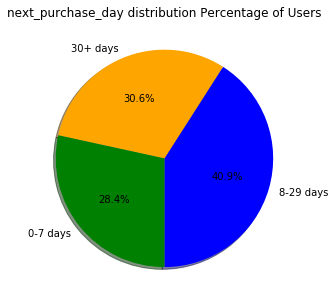

In [22]:
# Data to plot
sizes = users_df['next_purchase_day_3class'].value_counts()
print(sizes)
colors = ["blue","orange","green"] 
plt.rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode=None, labels=[ '8-29 days', '30+ days', '0-7 days'], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('next_purchase_day distribution Percentage of Users')
plt.show()

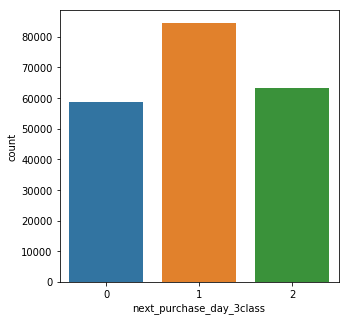

In [19]:
sns.countplot(users_df['next_purchase_day_3class'], label = "Count")

In [23]:
users_df.to_csv('existing_users_3classes_df.csv')
#prior_products_per_order.to_csv('prior_products_per_order.csv')
#user_order_product_df.to_csv('user_order_product_df.csv')

In [24]:
users_df.to_pickle('existing_users_3classes_df.pickle')
#prior_products_per_order.to_pickle('prior_products_per_order.pickle')
#user_order_product_df.to_pickle('user_order_product_df.pickle')

# Creating Additional Features after feature importance

These new features focus more on the most recent orders for each user (last 3 orders) and get the days since prior order for each and the mean

In [ ]:
orders_df = pd.read_sql('select user_id,order_number ,days_since_prior_order from orders where eval_set = "prior"', conn)

In [ ]:
orders_df['user_last_order_number'] = (orders_df.sort_values(by=['user_id','order_number'],ascending=False).groupby('user_id',as_index=False)['order_number'].nth(0))
(orders_df['user_last_order_number'])
orders_df['before_last'] = (orders_df['user_last_order_number']-1).shift(-2)
orders_df['before_before_last'] = (orders_df['user_last_order_number']-2).shift(-2)


In [ ]:
orders_df['user_days_between_last_2_orders'] = (np.where(orders_df['order_number'] == 
                                                      orders_df['user_last_order_number'],
                                                      orders_df['days_since_prior_order'],
                                                      np.nan))
orders_df['user_days_between_before_before_last_2_orders'] = (np.where(orders_df['order_number'] == 
                                                      orders_df['before_last'],
                                                      orders_df['days_since_prior_order'],
                                                      np.nan))
orders_df['user_days_between_before_before_last_2_orders'] = (np.where(orders_df['order_number'] == 
                                                      orders_df['before_before_last'],
                                                      orders_df['days_since_prior_order'],
                                                      np.nan))
orders_df.head(12)

In [ ]:
users_df['days_since_prior_order_1'] = list(orders_df.groupby('user_id')['user_days_between_last_2_orders'].median())
users_df['days_since_prior_order_2'] = list(orders_df.groupby('user_id')['user_days_between_before_last_2_orders'].median())
users_df['days_since_prior_order_3'] = list(orders_df.groupby('user_id')['user_days_between_before_before_last_2_orders'].median())

In [ ]:
users_df['days_between_last_3_orders_mean'] = (users_df['days_since_prior_order_1']+users_df['days_since_prior_order_2']+users_df['days_since_prior_order_3'])/3
users_df.head()

In [ ]:
users_df.to_pickle('existing_users_3classes_df-updatedfeatures.pickle')

# Divide the users into 2 classes based on next purchase day

In [ ]:
users_df['next_purchase_day_2class'] = 0
users_df.loc[users_df.next_purchase_day>7,'next_purchase_day_2class'] = 1
users_df.groupby('next_purchase_day_2class')['next_purchase_day'].describe()

In [ ]:
# Data to plot
sizes = users_df['next_purchase_day_2class'].value_counts()
print(sizes)
colors = ["blue","orange"] 
plt.rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode=None, labels=[ '>14 days', '<=14 days'], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('next_purchase_day distribution Percentage of Users')
plt.show()

In [ ]:
users_df.to_pickle('existing_users_2classes_df.pickle')